In [1]:
import skrf as rf
import numpy as np
# pyright: reportCallIssue=false

# Measurement Extraction
For physical measurements, a 2-port Rohde-Schwarz ZNC3-2Port VNA was used, calibrated in a frequency range from $0.5$ to $1.5$ GHz.
Since the Wilkinson divider has 3 ports, the S-parameter matrix is reconstructed through 3 separate measurements.

The VNA port -> Wilkinson port correspondence is:

| File | VNA Port | Device Port |
| ------- | ---------- | ------------------ |
| 1.s2p       | 1          | 2                  |
| 1.s2p       | 2          | 3                  |
| 2.s2p       | 1          | 1                  |
| 2.s2p       | 2          | 2                  |
| 3.s2p       | 1          | 1                  |
| 3.s2p       | 2          | 3                  |

Finally, we have another file 4.s2p, which contains the through connection between the two cables without any load in between to see the inherent ripple of the instrument/cables

First, we load the four measurement files

In [2]:
m1 = rf.Network('mediciones/1.s2p')
m2 = rf.Network('mediciones/2.s2p')
m3 = rf.Network('mediciones/3.s2p')
m4 = rf.Network('mediciones/4.s2p')

Then we create a three-port network corresponding to the Wilkinson divider called `wilkinson`

In [3]:
# Extract frequencies from the first file
freq = m1.frequency
# Generate zero matrix to initialize empty network
s_mat = np.zeros((len(freq), 3, 3), dtype=complex)
# Generate empty network
wilkinson = rf.Network(frequency=freq, s=s_mat, z0=50, name='Wilkinson 3-port')

The notation to refer to an S-parameter is `wilkinson.s[freq, Sa, Sb]`. To operate over all frequencies, simply work in full-range mode using `wilkinson.s[:, Sa, Sb]`. Indexing starts at 0, not 1, so to refer to, for example, the $S_{21}$ parameter across the entire available frequency spectrum, use `wilkinson.s[:, 1, 0]`

Now we will map all parameters stored in the .s2p files (each corresponding to a two-port network specified in the table) to the three-port network `wilkinson` corresponding to our power divider.

For transmission measurements, there is only one option in each case, so we simply map from the s2p file to the variable

In [4]:
# File 1.s2p (m1): VNA p1 -> Device p2 | VNA p2 -> Device p3
wilkinson.s[:, 2, 1] = m1.s[:, 1, 0]  # S21 from m1 -> S32 of device (transmission p2->p3)
wilkinson.s[:, 1, 2] = m1.s[:, 0, 1]  # S12 from m1 -> S23 of device (transmission p3->p2)

# File 2.s2p (m2): VNA p1 -> Device p1 | VNA p2 -> Device p2
wilkinson.s[:, 1, 0] = m2.s[:, 1, 0]  # S21 from m2 -> S21 of device (transmission p1->p2)
wilkinson.s[:, 0, 1] = m2.s[:, 0, 1]  # S12 from m2 -> S12 of device (transmission p2->p1)

# File 3.s2p (m3): VNA p1 -> Device p1 | VNA p2 -> Device p3
wilkinson.s[:, 2, 0] = m3.s[:, 1, 0]  # S21 from m3 -> S31 of device (transmission p1->p3)
wilkinson.s[:, 0, 2] = m3.s[:, 0, 1]  # S12 from m3 -> S13 of device (transmission p3->p1)

Now the reflections. There are 2 measurements of each since each port was used in two different files. Without information about which is more reliable, we take a simple average of all reflections

In [5]:
# Reflection S11 (average of m2 and m3)
aux = (m2.s[:, 0, 0] + m3.s[:, 0, 0]) / 2  # Average of S11 from m2 and S11 from m3
wilkinson.s[:, 0, 0] = aux  # S11 of device

# Reflection S22 (average of m1 and m2)
aux = (m1.s[:, 0, 0] + m2.s[:, 1, 1]) / 2  # S11 from m1 -> S22, S22 from m2 -> S22
wilkinson.s[:, 1, 1] = aux  # S22 of device

# Reflection S33 (average of m1 and m3)
aux = (m1.s[:, 1, 1] + m3.s[:, 1, 1]) / 2  # S22 from m1 -> S33, S22 from m3 -> S33
wilkinson.s[:, 2, 2] = aux  # S33 of device

Now the `wilkinson` block has the complete S-parameter matrix extracted through measurements.

# Plots
We plot transfer, matching, and isolation in three separate graphs using the `plot_s_parameters` function made separately to simplify and standardize plotting

We have three networks:

The first network is an ideal simulation made in ADS:

<img src="img/schematic.jpg" width="600">

I import that network and call it `wilkinson_ideal`

Then there's the simulation made in ADS where the physical block was simulated with substrate parameters and real resistors. I call that network `wilkinson_simulado`

<img src="img/simulado.jpg" width="600">

And finally, the real measurements extracted from the VNA that we've been working with so far, which we rename to `wilkinson_real`

<img src="img/terminado.jpg" width="600">

Since the simulations are exported as s3p parameters, i.e., 3-port network, not much processing is needed


In [6]:
# Prepare the three networks
wilkinson_ideal = rf.Network('simulaciones/ideal.s3p')
wilkinson_simulado = rf.Network('simulaciones/simulado.s3p')
wilkinson_real = wilkinson

In [7]:
from importlib import reload
import plot  # Import the module (not the function directly)

In [8]:
reload(plot)  # Reload the module from disk
from plot import plot_s_parameters  # Re-import the updated function

## Plotting function
Function saved in a separate file called `plotear.py` that plots with a standardized format for this case. The solid blue vertical lines are fixed at $1\text{GHz}$ while the dashed lines are the peaks (maximum or minimum as appropriate) of each curve. The value in $\text{GHz}$ of each dashed line is in the legend

## First, plot the ideal one

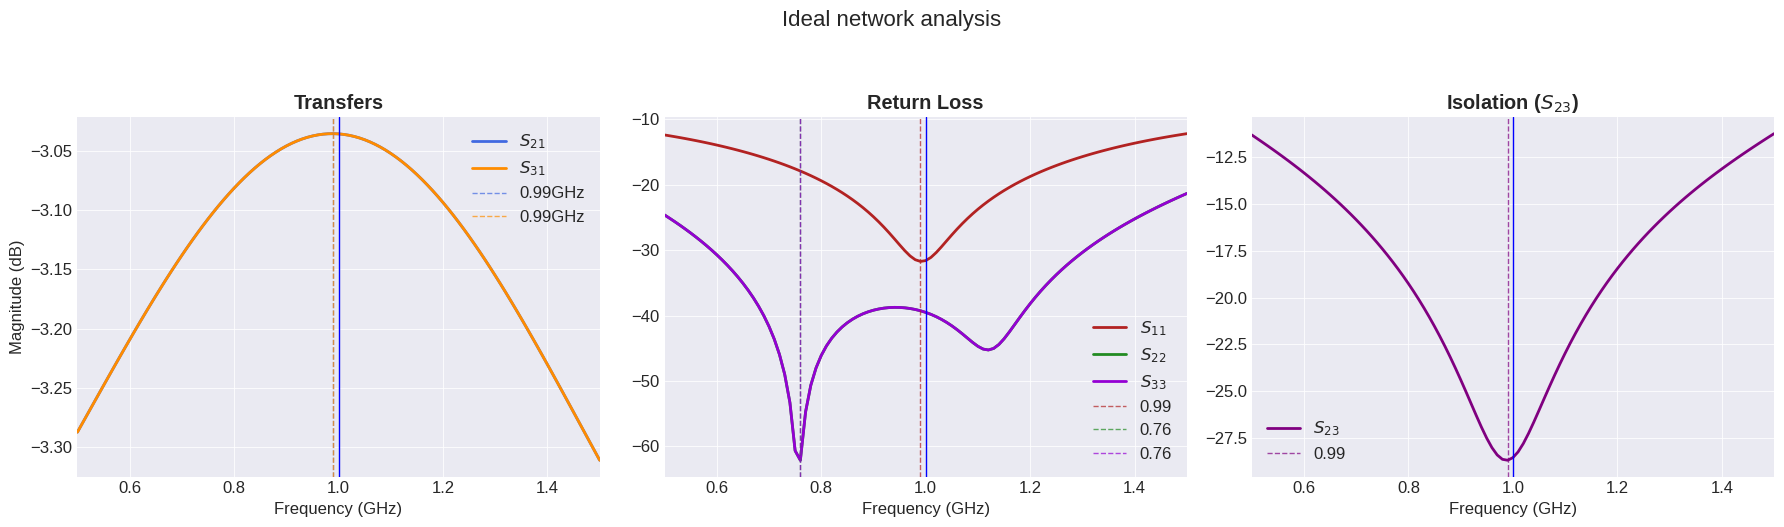

In [9]:
plot_s_parameters(wilkinson_ideal, 'Ideal network analysis', save_fig=True, autoscales=True)

Then plot the parameters from the simulation

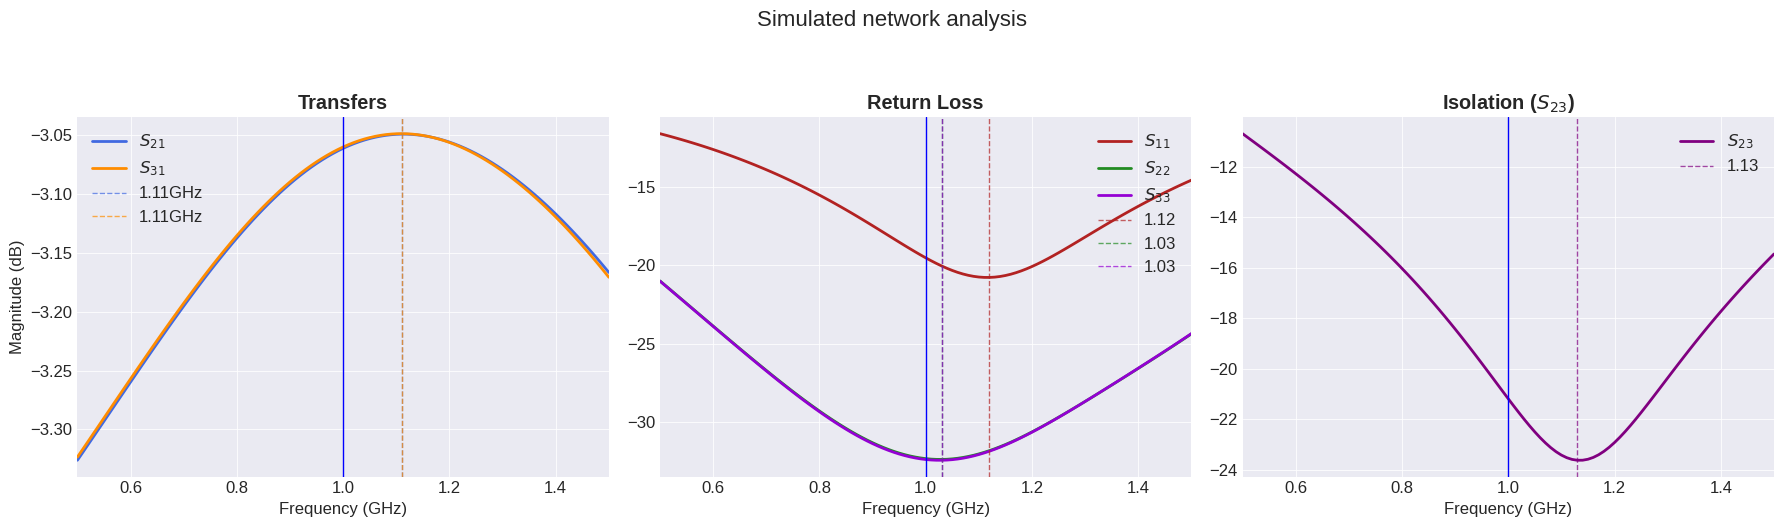

In [10]:
plot_s_parameters(wilkinson_simulado, 'Simulated network analysis', save_fig=True, autoscales=True)

And finally from the measured parameters

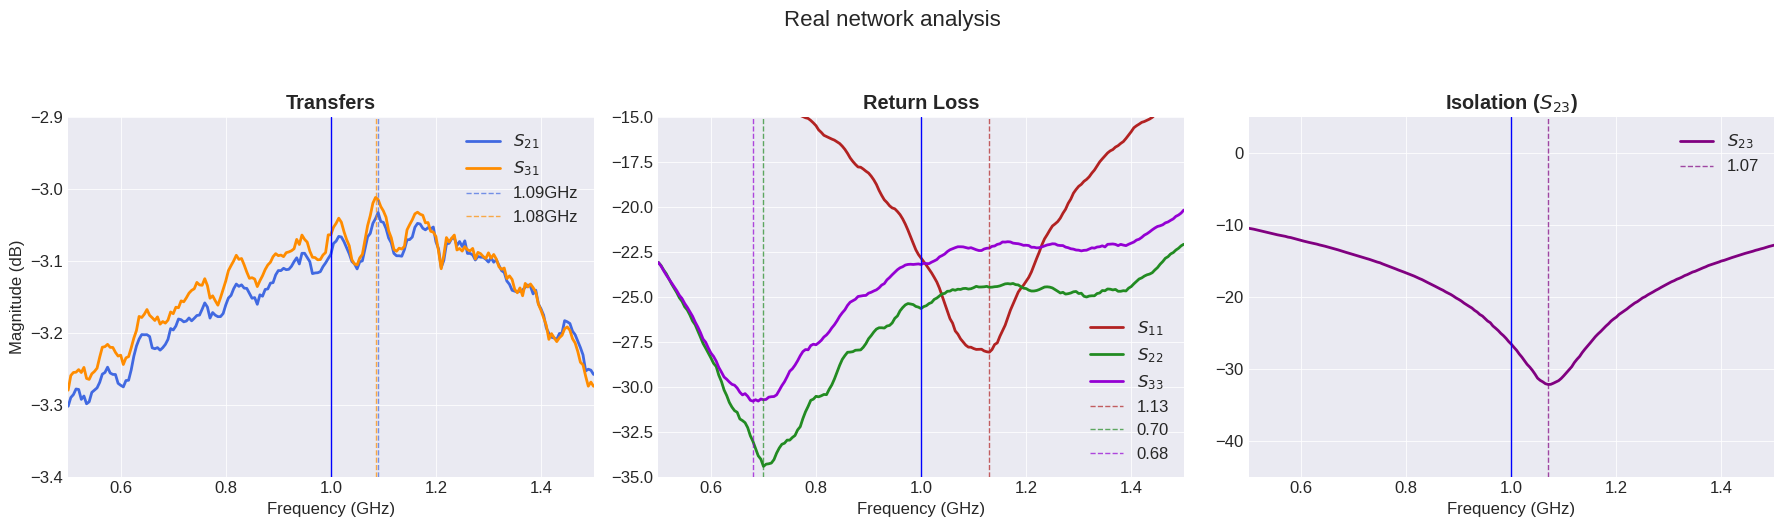

In [11]:
plot_s_parameters(wilkinson_real, 'Real network analysis', save_fig=True, autoscales=False)

Apart from the marked ripple, it can be seen that the trends are maintained regarding the peaks next to the phase shift

# Instrument Error Correction
We also captured the `.s2p` parameters of a direct connection between the cables to see the ripple of our setup

In [12]:
through = rf.Network(frequency = m4.frequency, s = m4.s, z0=50, name='Through')

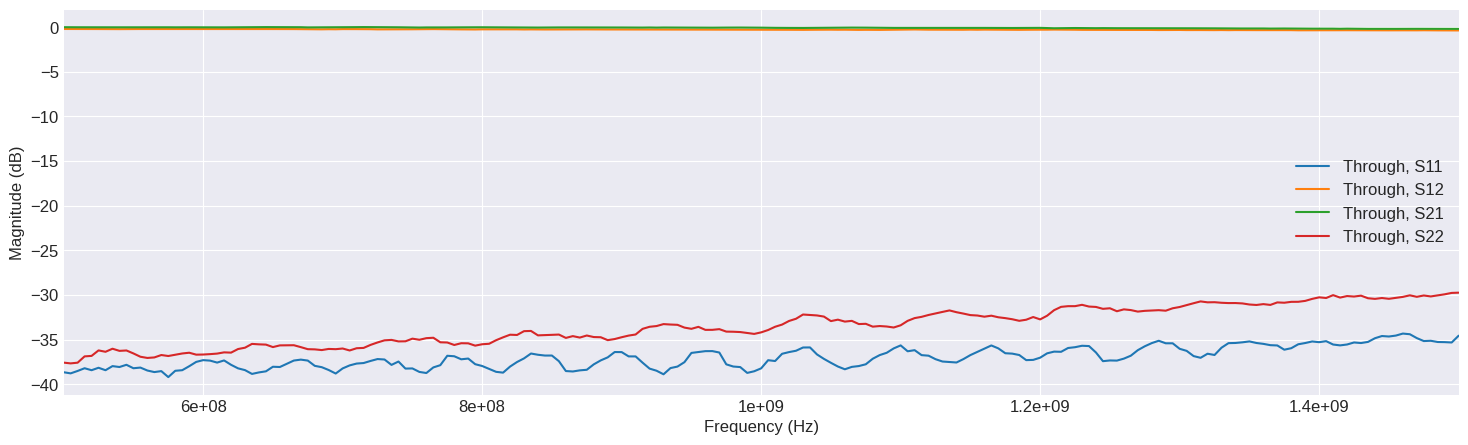

In [13]:
through.plot_s_db()

There is a huge difference between the transfers and the reflections. Focusing on the transfers

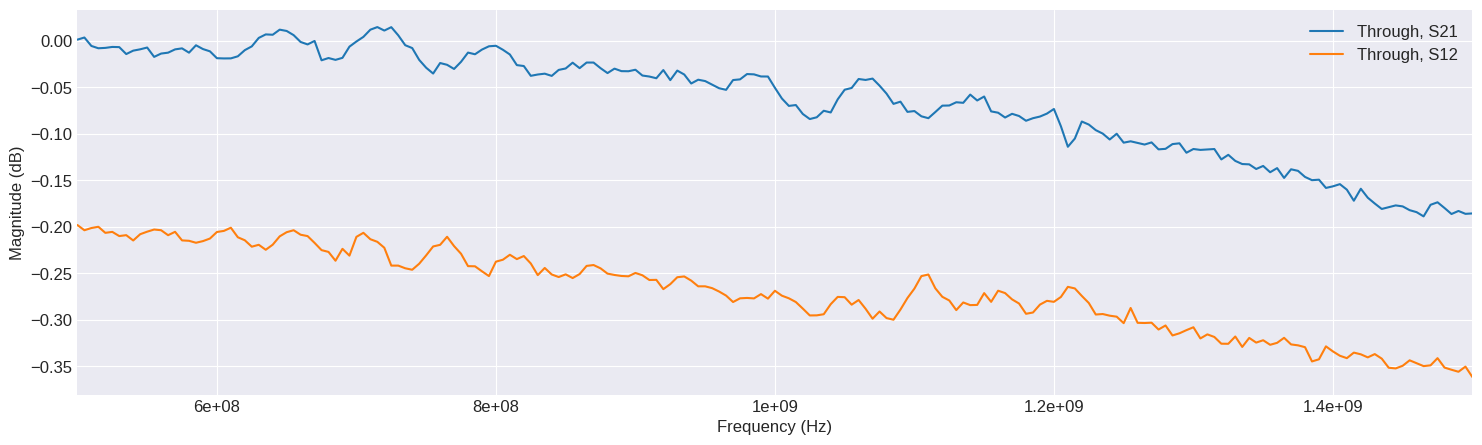

In [14]:
through.plot_s_db(m=1, n=0)
through.plot_s_db(m=0, n=1)

Aha, here yes, however the amplitudes look about 0.05. Little.

To create a new network with the correction applied, I will need the correspondence between the original VNA ports and the ports of the `wilkinson` network.<br>
For example: The transfer $S_{31}$ of the Wilkinson network corresponds to the transfer $S_{21}$ of file `3.s2p`. Therefore, we need to do $S_{31}(\text{Wilkinson}) \cdot S_{21}^{-1}(\text{VNA})$, that is, the transfer of the network assembled from the device measurements multiplied by the inverse of the transfer measured in the cables. The reflections are averaged; in the case of $S_{22}$, I recalculate it using only $S_{11}$ from `2.s2p` since it was measured from two different VNA ports. The other two reflections are consistent. Here we must not make mistakes.

## Original file table

| File | VNA Port | Device Port |
| ------- | ---------- | ------------------ |
| 1.s2p       | 1          | 2                  |
| 1.s2p       | 2          | 3                  |
| 2.s2p       | 1          | 1                  |
| 2.s2p       | 2          | 2                  |
| 3.s2p       | 1          | 1                  |
| 3.s2p       | 2          | 3                  |

## Correction correspondence

| Wilkinson | Correction
| --------- | ---------------
| $S_{11}$  | $S_{11}$   |
| $S_{22}$  | $S_{11}$   |
| $S_{33}$  | $S_{22}$   |
| $S_{21}$  | $S_{21}$   |
| $S_{31}$  | $S_{21}$   |
| $S_{23}$  | $S_{12}$   |
| $S_{32}$  | $S_{21}$   |

We invert the through matrix to apply the corrections

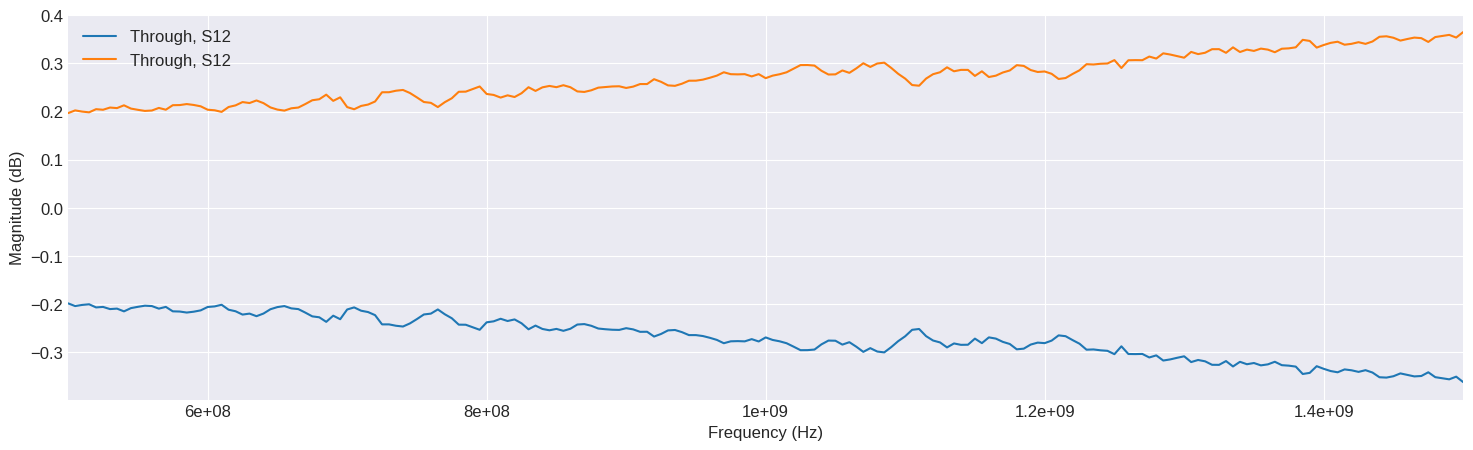

In [15]:
through.plot_s_db(0, 1)
through.inv.plot_s_db(0, 1)

In [16]:
correccion = through.inv

In [17]:
# Recalculate S11
wilkinson.s[:, 0, 0] = m2.s[:, 0, 0]

In [18]:
wilkinson_fix = wilkinson.copy()

In [19]:
wilkinson_fix.s[:, 0, 0] = wilkinson.s[:, 0, 0] * correccion.s[:, 0, 0]
wilkinson_fix.s[:, 1, 1] = wilkinson.s[:, 1, 1] * correccion.s[:, 0, 0]
wilkinson_fix.s[:, 2, 2] = wilkinson.s[:, 2, 2] * correccion.s[:, 1, 1]
wilkinson_fix.s[:, 1, 0] = wilkinson.s[:, 1, 0] * correccion.s[:, 1, 0]
wilkinson_fix.s[:, 2, 1] = wilkinson.s[:, 2, 1] * correccion.s[:, 1, 0]
wilkinson_fix.s[:, 1, 2] = wilkinson.s[:, 1, 2] * correccion.s[:, 0, 1]

Ta-daa! Let's see the corrected plots

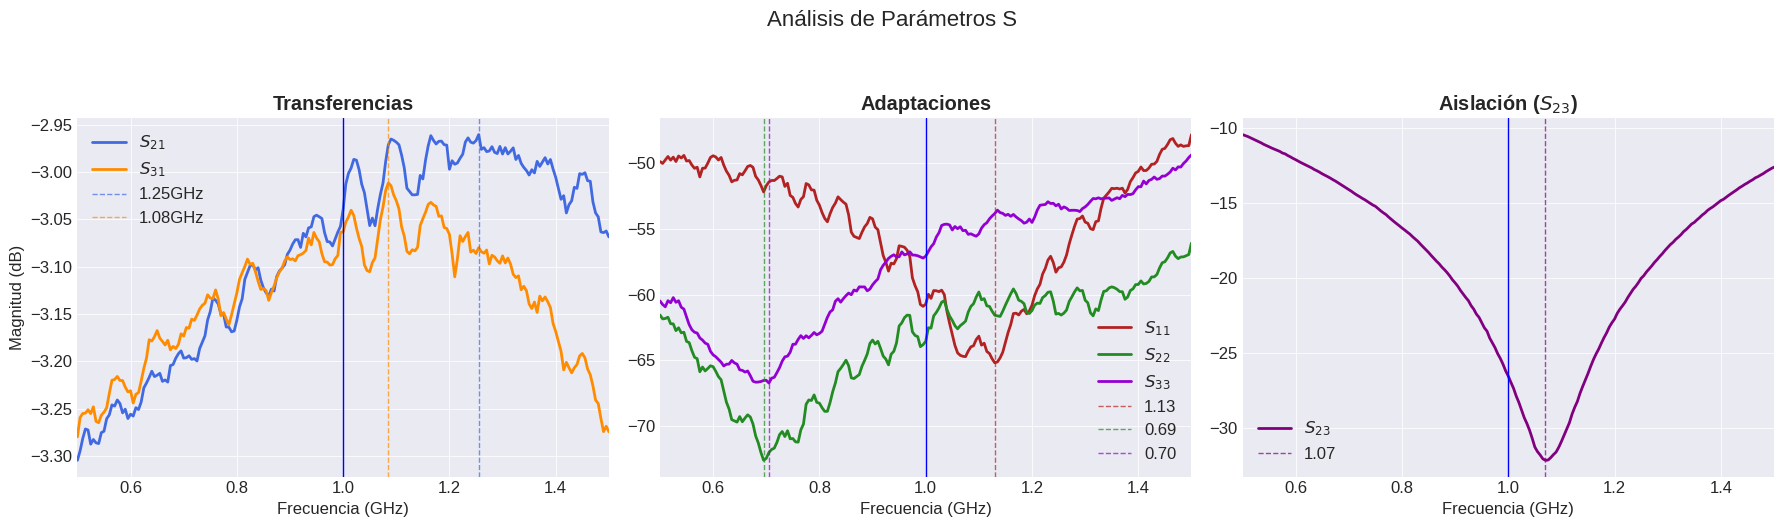

In [20]:
plot_s_parameters(wilkinson_fix, autoscales=True)

The matching values are exaggerated since we are adding the dB of the original matching plus those of the through matching (which doesn't give zero) so I leave them out of the calculation. I revert the corrected network to return the reflections to their original values

In [21]:
wilkinson_fix.s[:, 0, 0] = wilkinson.s[:, 0, 0]
wilkinson_fix.s[:, 1, 1] = wilkinson.s[:, 1, 1]
wilkinson_fix.s[:, 2, 2] = wilkinson.s[:, 2, 2]

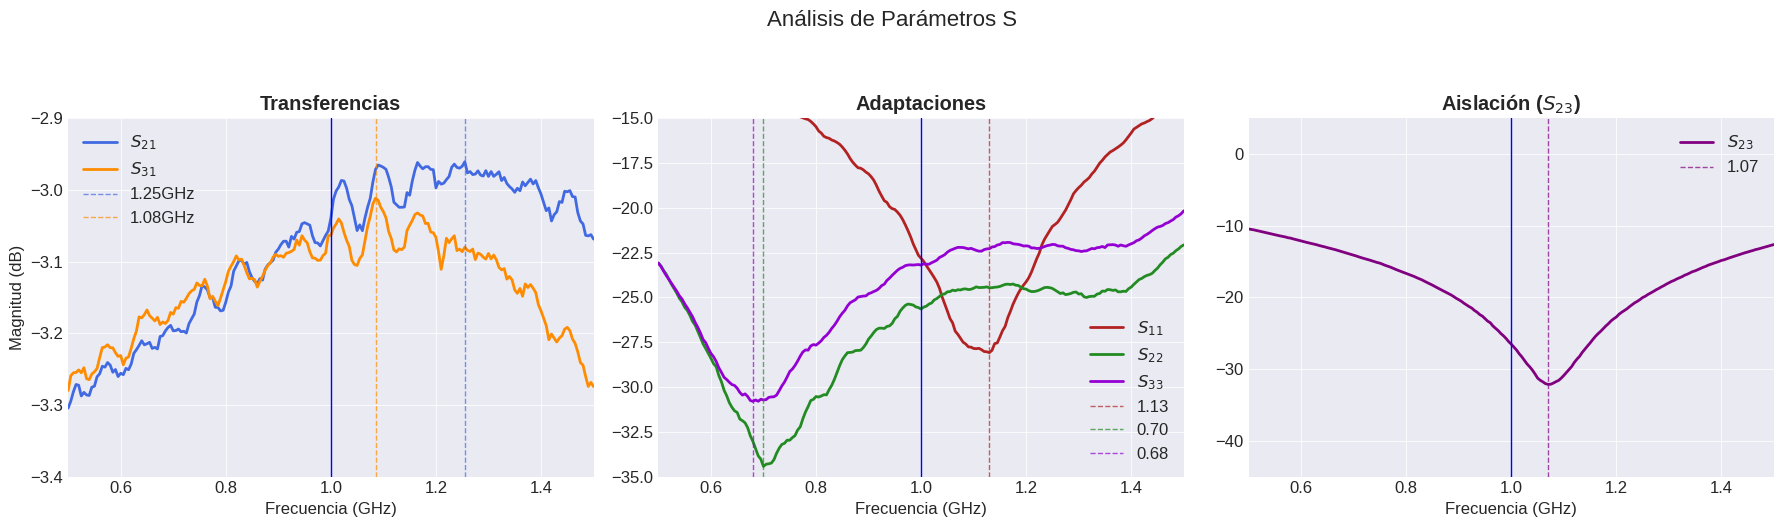

In [22]:
plot_s_parameters(wilkinson_fix, autoscales=False)

Let's see against the uncorrected one

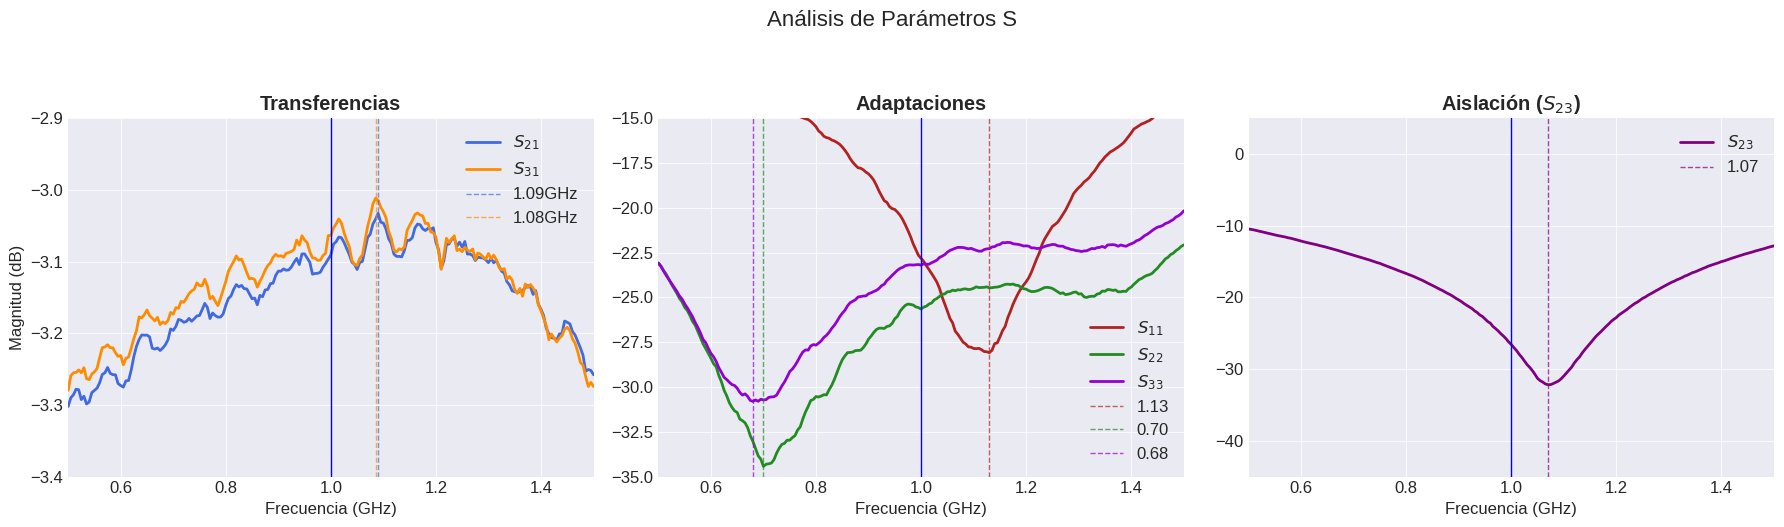

In [23]:
plot_s_parameters(wilkinson_real)

In this case, $S_{21}$ improves quite a bit in terms of bandwidth but the ripple is not solved